## Load Data

### Calculating Fingerprints

In [25]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

supplier = Chem.SDMolSupplier('data/cas_4337.sdf')
infos = [{} for mol in supplier]
fingerprints = np.array([AllChem.GetMorganFingerprintAsBitVect(supplier[i], 3, nBits=2048, bitInfo=infos[i]) 
                         for i in range(len(supplier))])

### Splitting Dataset

into train and validation sets

In [26]:
valid_ids = [6,   10,   29,   32,   42,   58,   72,   83,   98,  100,  128, 
        145,  148,  168,  171,  205,  208,  237,  244,  285,  290,  291,
         300,  312,  332,  334,  335,  347,  356,  369,  371,  377,  407,
         424,  456,  458,  470,  472,  486,  514,  515,  528,  557,  563,
         599,  610,  616,  628,  640,  701,  704,  722,  764,  794,  818,
         821,  840,  850,  856,  859,  874,  878,  882,  898,  901,  925,
         936,  945,  957,  974,  977, 1013, 1019, 1030, 1038, 1047, 1049,
        1072, 1073, 1100, 1159, 1168, 1187, 1190, 1194, 1201, 1202, 1233,
        1247, 1258, 1264, 1273, 1283, 1288, 1300, 1302, 1319, 1339, 1349,
        1402, 1413, 1416, 1422, 1426, 1435, 1454, 1465, 1483, 1502, 1513,
        1515, 1520, 1548, 1576, 1604, 1606, 1621, 1650, 1695, 1696, 1711,
        1714, 1716, 1725, 1743, 1746, 1752, 1780, 1788, 1794, 1799, 1813,
        1826, 1866, 1886, 1901, 1903, 1921, 1929, 1940, 1969, 1970, 1997,
        1998, 2008, 2010, 2011, 2018, 2023, 2046, 2060, 2064, 2080, 2081,
        2131, 2171, 2182, 2203, 2212, 2224, 2231, 2241, 2246, 2283, 2294,
        2295, 2297, 2327, 2329, 2331, 2349, 2357, 2360, 2365, 2397, 2413,
        2417, 2418, 2421, 2448, 2467, 2510, 2516, 2528, 2533, 2549, 2562,
        2601, 2604, 2606, 2609, 2611, 2632, 2644, 2653, 2677, 2682, 2685,
        2692, 2703, 2708, 2714, 2719, 2726, 2732, 2759, 2761, 2776, 2780,
        2817, 2818, 2829, 2837, 2857, 2858, 2884, 2899, 2902, 2905, 2911,
        2939, 2975, 2977, 2986, 3007, 3009, 3018, 3024, 3038, 3066, 3087,
        3098, 3107, 3117, 3122, 3139, 3157, 3161, 3164, 3217, 3223, 3233,
        3263, 3265, 3271, 3290, 3295, 3307, 3313, 3317, 3321, 3382, 3384,
        3388, 3400, 3409, 3412, 3419, 3423, 3449, 3470, 3487, 3488, 3503,
        3509, 3511, 3539, 3562, 3626, 3637, 3654, 3662, 3663, 3668, 3671,
        3688, 3689, 3695, 3710, 3726, 3743, 3744, 3782, 3791, 3794, 3808,
        3809, 3841, 3849, 3874, 3910, 3912, 3925, 3945, 3950, 3958, 3959,
        3962, 3964, 3967, 3978, 3993, 4009, 4010, 4055, 4057, 4085, 4089,
        4096, 4099, 4107, 4112, 4129, 4135, 4151, 4155, 4196, 4209, 4216,
        4234, 4236, 4251, 4267, 4283, 4317, 4326, 4335
]

In [27]:
X_train = []
X_valid = []
for i in range(len(fingerprints)):
    if i in valid_ids:
        X_valid.append(fingerprints[i])
    else:
        X_train.append(fingerprints[i])
X_train = np.array(X_train)
X_valid = np.array(X_valid)

Collecting the lables from the supplier

In [28]:
y_train, y_valid, i = [], [], 0
for mol in supplier:
    if mol.GetProp("Ames test categorisation") == "mutagen":
        if i in valid_ids:
            y_valid.append(1)
        else:
            y_train.append(1)
    else:
        if i in valid_ids:
            y_valid.append(0)
        else:
            y_train.append(0)
    i+=1
    
y_train = np.array(y_train)
y_valid = np.array(y_valid)

## Optimizing Model's Architecture

Using the Bayesian Inference

In [58]:
from keras.models import Sequential
from keras.layers import Activation, Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam

from sklearn.metrics import roc_auc_score

import time

from bayes_opt import BayesianOptimization

In [115]:
param_reference = {'init': ['lecun_uniform', 'he_uniform'],
             'activation': ['relu', 'sigmoid', 'selu'],
              'optimizer': [SGD, Adam]
                  }

search_space = {'units': (5, 2048), # discrete
                'activation': (0, 2), # categorical
                'optimizer': (0, 2), # categorical
                'lr': (.00001, .2), # continuous
                'n_layers': (2, 15), # discrete
                'epochs': (5, 30), # discrete
                'batch_size': (1, 200), # discrete
                'momentum': (0.001, 0.5), # continuous
                'init': (0, 1), # categorical
                'dropout_rate': (0.0001, 0.9) # continuous
               }



input_dim = X_valid.shape[1]
def train_evaluate_and_auc(units, activation, optimizer, lr, n_layers, epochs, batch_size, momentum, init, dropout_rate):
    # handle categorical
    activation = param_reference['activation'][int(round(activation))]
    optimizer = param_reference['optimizer'][int(round(optimizer))]
    init = param_reference['init'][int(round(init))]
    # handle discrete
    units = int(round(units))
    n_layers = int(round(n_layers))
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    
    # build classifier with corresponding hyperparameters
    keras.backend.clear_session()
    classifier = Sequential()
    classifier.add(
        Dense(units=units, input_dim=input_dim, activation=activation, kernel_initializer=init) # input layer
    )
    # Create an arbitrary number of Hidden Layers
    for n in range(n_layers):
        classifier.add(Dense(units=units, activation=activation))
        classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units=1, activation='sigmoid'))     # Output Layer
    if optimizer == SGD:
        optimizer = SGD(learning_rate=lr, momentum=momentum)
    else:
        optimizer = Adam(learning_rate=lr)
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # FIXME: adjust epochs and batch size
    classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    return roc_auc_score(y_valid, classifier.predict(X_valid))

In [57]:
start_time = time.ctime()
optimization = BayesianOptimization(f=train_evaluate_and_auc, pbounds=search_space, random_state=0)
optimization.maximize(init_points=10, n_iter=30)
print("Bayesian Optimization took {}".format(time.ctime() - start_time))

print(optimization.max)
# for i, res in enumerate(optimization.res):
#     print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | activa... | batch_... | dropou... |  epochs   |   init    |    lr     | momentum  | n_layers  | optimizer |   units   |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7511   |  0.5488   |  38.61    |  0.5822   |  15.45    |  0.4237   |  0.006813 |  0.375    |  4.675    |  0.9637   |  22.25    |
|  2        |  0.7748   |  0.7917   |  31.16    |  0.5544   |  19.26    |  0.07104  |  0.001784 |  0.2081   |  4.498    |  0.7782   |  44.15    |
|  3        |  0.7762   |  0.9786   |  41.97    |  0.4692   |  17.81    |  0.1183   |  0.006759 |  0.2573   |  4.834    |  0.5218   |  23.66    |
|  4        |  0.8575   |  0.2646   |  40.97    |  0.4649   |  15.68    |  0.01879  |  0.006559 |  0.4448   |  3.851    |  0.9437   |  35.68    |
|  5        |  0.6349   |  0.3595   |  27.48    |  0.6581   |  10.6     |  0.6668   |  0.007036 |  0.2842   |  2.387    |  0

### Set of best hyperparameters

Because the optimization treats all hyperparameters in a continuous way, let's convert them into a interpretable way.

In [100]:
import re
def convert_to_interpretable_dict(optimization_max):
    """ Returns an interpretable dictionary given the a single dictionary from the Bayesian Optimization object above
    """
    interpretable_dict = {}
    interpretable_dict['AUC'] = optimization_max['target']
    interpretable_dict['activation'] = param_reference['activation'][int(round(optimization_max['params']['activation']))] # categorical
    interpretable_dict['batch_size'] = int(round(optimization_max['params']['batch_size']))
    interpretable_dict['dropout_rate'] = optimization_max['params']['dropout_rate']
    interpretable_dict['epochs'] = int(round(optimization_max['params']['epochs']))
    interpretable_dict['init'] = param_reference['init'][int(round(optimization_max['params']['init']))] # categorical
    interpretable_dict['lr'] = optimization_max['params']['lr']
    interpretable_dict['momentum'] = optimization_max['params']['momentum']
    interpretable_dict['n_layers'] = int(round(optimization_max['params']['n_layers']))
    interpretable_dict['optimizer'] = re.findall("[A-Z|a-z]+\'", str(param_reference['optimizer'][int(round(optimization_max['params']['optimizer']))]))[0][:-1] # categorical
    interpretable_dict['units'] = int(round(optimization_max['params']['units']))
    return interpretable_dict

In [103]:
import pandas as pd

interpretable_dict = convert_to_interpretable_dict(optimization.max)
pd.DataFrame.from_dict(interpretable_dict, orient='index', columns=['Best']).T.style.set_caption("Results of Bayesian Optimization: best set of hyperparameters")

,AUC,activation,batch_size,dropout_rate,epochs,init,lr,momentum,n_layers,optimizer,units
Best,0.877166,relu,10,0.1,10,lecun_uniform,0.01,0.6,2,Adam,50


## Running Model on Test set

In [118]:
# build model with corresponding hyperparameters
keras.backend.clear_session()
model = Sequential()
model.add(
    Dense(units=50, input_dim=X_valid.shape[1], activation='relu', kernel_initializer='lecun_uniform') # input layer
)
# Create an arbitrary number of Hidden Layers
for n in range(2):
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))     # Output Layer
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# FIXME: adjust epochs and batch size
model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=0)

In [104]:
import csv

smiles, y_test = [], []
with open('data/test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        if row[1] != 'smiles':
            # read smiles from the 2nd column
            smiles.append(row[1])
            # read labels from the 3rd column
            y_test.append(row[2])

In [105]:
info_dicts, X_test = [], []
for smile in smiles:
    m = Chem.MolFromSmiles(smile)
    info = {}
    bit_vector = AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048, bitInfo=info)
    X_test.append(bit_vector)
    info_dicts.append(info)
    
X_test = np.array(X_test)
y_test = np.array(y_test, dtype=np.int8)

### Plotting test set ROC

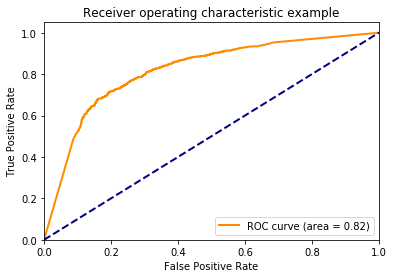

In [119]:
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc(fpr, tpr, auc)

## Loading and Reevaluating Previous Model

This is just a sanity check that I'd like to make because th repository has been a mess in the recent while. So in order to check that this model has the same weights as the one reported in my last report, I am going to load it and then reevaluate it on the test set, and see if I get the same AUC score.

In [11]:
import tensorflow as tf
import pixiedust
from tensorflow import keras
from keras.models import model_from_json
import json

# open json file and read content
with open('analysis_best_model/best_model.json','r') as f:
    json_string = f.readline()
# deserialize the json data into a keras model (only structure)
model = model_from_json(json_string)
# load the adjusted weights of the model
model.load_weights('analysis_best_model/best_model.h5')
# print a summary of the structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

### Read Dataset

In [2]:
import csv

smiles, y_test = [], []
with open('data/test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        if row[1] != 'smiles':
            # read smiles from the 2nd column
            smiles.append(row[1])
            # read labels from the 3rd column
            y_test.append(row[2])

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

info_dicts, X_test = [], []
for smile in smiles:
    m = Chem.MolFromSmiles(smile)
    info = {}
    bit_vector = AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048, bitInfo=info)
    X_test.append(bit_vector)
    info_dicts.append(info)
    
X_test = np.array(X_test)
y_test = np.array(y_test, dtype=np.int8)

### Evaluation

Done! No need to re-run this

In [106]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

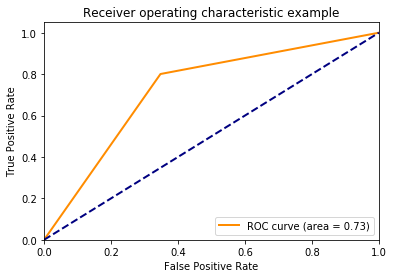

In [5]:
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_pred = model.predict_classes(X_test)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc(fpr, tpr, auc)

## Converting Keras Model to Tensorflow

Blackbox function from the Tensorflow documentation that converts a Keras model to a Tensorflow one.

In [ ]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Then we save the tensorflow graph to a file under `model/tf_best_model.pb`

In [ ]:
# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "analysis_best_model", "tf_best_model.pb", as_text=False)

## Reload the Tensorflow graph model

As of this point, we can forget about the Keras graph model from before.

In [ ]:
import tensorflow as tf
from tensorflow.python.platform import gfile

f = gfile.FastGFile("./analysis_best_model/tf_best_model.pb", 'rb')
graph_def = tf.GraphDef()
# Parses a serialized binary message into the current message.
graph_def.ParseFromString(f.read())
f.close()

with tf.Session() as sess:
    sess.graph.as_default()
    # Import a serialized TensorFlow `GraphDef` protocol buffer
    # and place into the current default `Graph`.
    g_in = tf.import_graph_def(graph_def)
    writer = tf.summary.FileWriter('analysis_best_model'+'/log/')
    writer.add_graph(sess.graph)
    writer.flush()
    writer.close()

### Visualize the graph

In [ ]:
from show_graph import show_graph
import tensorflow as tf
f = gfile.FastGFile("./analysis_best_model/tf_best_model.pb", 'rb')
graph_def = tf.GraphDef()
# Parses a serialized binary message into the current message.
graph_def.ParseFromString(f.read())
# Show current session graph with TensorBoard in Jupyter Notebook.
show_graph(graph_def)

## Integrated Gradients

In the following we provide an implementation for the integrated gradients. Steps of the implementation are:
1. Consider a black image (each pixel 0) as a baseline
2. Now, interpolate a series of images , increasing in intensity, between the baseline image and the original image
3. The scores of these images (softmax output) when plotted, will look like the following.
4. Our region of interest lies where the slope of the score vs intensity graph doesn't remain stagnant. We call these gradients - *interesting gradients*
5. Gradients of the output with respect to these series of interpolated images, when calculated gives us the following
6. The integration of these series of gradients give us the Integrated gradients of the image.

*Right while I'm writing this implementation below, I came to realize that there's an easier way to get the gradients instead of calculating them manually, which through Keras's function `get_gradients()` of the Sequential model. **See therefore that you update the your model's implementation according to the Keras's new implementation**.*

#### Why/What it's not working

The function from **<font style="font-family: times; font-size: 14pt">Keras</font>** for calculating gradients isn't working.

In [ ]:
%%pixie_debugger
prediction_tensor = model.predict(X_test) # prediciton tensor
input_tensor = X_test # input tensor
gradients = tf.gradients(prediction_tensor, input_tensor)
# compute the gradient of the input picture wrt this loss
# grads = K.gradients(loss, input_img)[0]

#### Author Implementation

In the following cell, I provide the implementation of the integrated gradients that the author provides (<u>not working</u>).

In [6]:
a = tf.constant(0.)
with tf.GradientTape() as tape:
    tape.watch(a)
    b = 2 * a
    g = tape.gradient(b, [a, b])
    
g

[<tf.Tensor 'Mul_2:0' shape=() dtype=float32>,
 <tf.Tensor 'ones:0' shape=() dtype=float32>]

In [7]:
model.predict(t_input, steps=1)

NameError: name 't_input' is not defined

This cell is working accordingly.

In [14]:
# %%pixie_debugger
t_input = tf.constant(X_test[0].reshape(1, -1), dtype=np.float32)
with tf.GradientTape() as tape:
    tape.watch(t_input)
    t_output = tf.convert_to_tensor(model.predict(t_input, steps=1), dtype=tf.float32)
    g = tape.gradient(t_output, t_input)
    
g

In [16]:
type(g)

NoneType

In [ ]:
import tensorflow as tf
grad_ys = []

t_input = tf.convert_to_tensor(X_test[0]) # input tensor
t_prediction = tf.convert_to_tensor(model.predict(X_test[0].reshape(1, -1))) # output tensor
t_gradients = tf.gradients(t_prediction, t_input, grad_ys=grad_ys)
print(t_gradients)

This is a very interesting cell! Apparently that's the right result of the function.

In [ ]:
%%pixie_debugger
import tensorflow as tf
# return the probability scalar and convert it to tensor
t_prediction = tf.convert_to_tensor(model.predict(X_test[0].reshape(1, -1)))
# create a list of variables
t_input = [tf.Variable(X_test[0])]
tf.keras.backend.gradients(t_prediction, t_input)

In [ ]:
import tensorflow as tf
from keras import backend as keras
import numpy as np
# stub function
# def input_tensor():
#     return model.input
# # stub function
# def prediciton_tensor(label):
#     return model.output

def integrated_gradients(inp, baseline, label, steps=50):
    t_input = input_tensor() # input tensor
    t_prediction = prediciton_tensor(label) # output tensor
    t_gradients = tf.gradients(t_prediction, t_input)[0] # gradients
    path_inputs = [baseline + (i/steps)*(inp-baseline) for i in range(steps)]
    grads = run_network(t_gradients, path_inputs)
    return (inp-baseline)*np.average(grads, axis=0) # integration

#### My Implementation (not working)

In the following, I provide my own implementation of the integrated gradients according to my understanding of the math formula in the paper(<u>not working</u>).

In [ ]:
from keras import backend as k
import numpy as np

# def integrated_gradients(inp, output_tensor, baseline=None, steps=50):
"""My own implementation of the integrated gradients. I've made this over the formula under section "Computing
Integrated Gradients". I'm not sure of the output of this function yet
@Params
------
input_tensor:         array of path values (all alphas)
output_tensor: of type Tensor
baseline:      (Optional) The baseline vector - if not provided, the zero-vector/tensor is calcualted.
steps:         (Optional), number of steps for integral estimation.

@Returns
-------
Attribution vector
"""
# for the first molecule
gradients = []
for alpha in range(steps):
    # gamma calculates the path function for a given alpha
    gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)
    baseline = np.zeros(shape=X_test[0].shape)
    input_tensor_ = tf.convert_to_tensor(gamma(alpha)) # input_tensor tensor
    # gradient of the output w.r.t. path function
    output = tf.convert_to_tensor(model.predict(gamma(alpha).reshape(1, -1))) # output tensor
    gradient = k.gradients(output, input_tensor)[0]
    print(gradient)
    gradients.append(gradient)
    
attributions = (inp - baseline)*np.average(gradients)
print(attributions)

# integrated_gradients(X_test[0], model.output)

In [ ]:
baseline = np.zeros(shape=inp.shape)
steps = 50
gamma = lambda alpha: baseline + float(alpha)/steps*(inp - baseline)
print(type(gamma(0.5)))
xx = tf.convert_to_tensor(gamma(0.5))
print(type(xx))

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# model.predict(gamma(2/steps))
inp = X_test[478]
print("Is gamma equal to input when alpha=1?")
print(gamma(1) == inp)
print("Is gamma equal to baseline when alpha=0?")
print(gamma(0) == baseline)
print("Is gamma equal to baseline when alpha=1?")
print(gamma(1) == baseline)
print("Is gamma equal to input when alpha=0?")
print(gamma(0) == input)

## Using GitHub Implemention

Just for the sake of visualization, I'm using this package. However, once my implementation is successfully working, I will change it.

In [22]:
print(model.optimizer)

None


In [17]:
from IntegratedGradients import integrated_gradients as IG
ig = IG(model)
ig.explain(X_test[0])

Evaluated output channel (0-based index): All
Building gradient functions


/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


AttributeError: 'NoneType' object has no attribute 'get_gradients'

In [ ]:
outputTensor = model.output #Or model.layers[index].output
listOfVariableTensors = model.trainable_weights
gradients = k.gradients(outputTensor, listOfVariableTensors)

In [ ]:
k.gradients(model.output, # here I need a variable)

## Visualizing the Attribution

apparently what needs to be done here is to replace the `DataStructs.TanimotoSimilarity` with the my own attribution score that I get, in order to visualize the attribution correctly. However, I still don't know what type of function that is.

Additionally, I should provide the zero-vector for the reference fingerprints.

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs

mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
                                                               metric=DataStructs.TanimotoSimilarity)